In [155]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

## Data Cleaning & Labeling

In [156]:
df = pd.read_csv("SpamCollection.csv", encoding="latin1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [157]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [158]:
df = df[['v1', 'v2']] # Keep only relevant columns
df.columns = ['label', 'text'] # Rename columns

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label']) # Convert ham/spam to 0/1
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Define the hyperparameter

In [159]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [160]:
# Define hyperparameters
vocab_size = 5000          # Only keep top most common words
embedding_dim = 64         # Embedding Size, words will be represented by a 64-number vector
max_length = 200           # Max number of words per message
trunc_type = 'post'        # Cut off extra words at the end
padding_type = 'post'      # Pad 0 at the end of short messages
oov_token = "<OOV>"        # For words not in vocabulary

In [161]:
# Create tokenizer and fit it on the text messages
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df['text'])

# Convert text messages to sequences of word indexes
sequences = tokenizer.texts_to_sequences(df['text'])

# Pad the sequences to make all same length
padded_sequences = pad_sequences(sequences, maxlen=max_length,
                                 padding=padding_type, truncating=trunc_type)

## Split data

In [162]:
X = padded_sequences
y = df['label'].values   # These are your answers: 0 = ham, 1 = spam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Build the (Gated Recurrent Unit) GRU model

In [163]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

In [164]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=200),
    GRU(64),
    Dense(1, activation='sigmoid')
])

In [165]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [166]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 64)           320000    
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 345025 (1.32 MB)
Trainable params: 345025 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train GRU Model

In [167]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/15
140/140 [==============================] - 13s 83ms/step - loss: 0.4188 - accuracy: 0.8602 - val_loss: 0.4052 - val_accuracy: 0.8601
Epoch 2/15
140/140 [==============================] - 11s 79ms/step - loss: 0.3922 - accuracy: 0.8674 - val_loss: 0.4048 - val_accuracy: 0.8601
Epoch 3/15
140/140 [==============================] - 11s 78ms/step - loss: 0.3939 - accuracy: 0.8674 - val_loss: 0.4072 - val_accuracy: 0.8601
Epoch 4/15
140/140 [==============================] - 11s 76ms/step - loss: 0.3933 - accuracy: 0.8674 - val_loss: 0.4049 - val_accuracy: 0.8601
Epoch 5/15
140/140 [==============================] - 10s 75ms/step - loss: 0.3928 - accuracy: 0.8674 - val_loss: 0.4098 - val_accuracy: 0.8601
Epoch 6/15
140/140 [==============================] - 11s 77ms/step - loss: 0.3920 - accuracy: 0.8674 - val_loss: 0.4067 - val_accuracy: 0.8601
Epoch 7/15
140/140 [==============================] - 11s 76ms/step - loss: 0.3921 - accuracy: 0.8674 - val_loss: 0.4069 - val_accuracy:

## Visualize & Evaluate Result

def plot_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

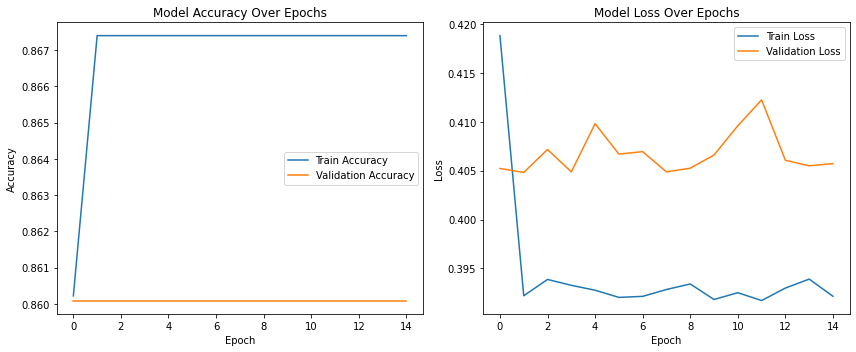

In [168]:
plot_history(history)

In [169]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=2)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

35/35 - 1s - loss: 0.4057 - accuracy: 0.8601 - 514ms/epoch - 15ms/step
Test Loss: 0.4057
Test Accuracy: 0.8601
140/140 - 2s - loss: 0.3915 - accuracy: 0.8674 - 2s/epoch - 15ms/step
Train Loss: 0.3915
Train Accuracy: 0.8674


## Test Model

In [170]:
def predict_message(text):
    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad it to the same length
    padded = pad_sequences(sequence, maxlen=200, padding='post', truncating='post')
    
    # Predict
    prob = model.predict(padded)[0][0]
    label = "spam" if prob > 0.5 else "ham"

    print(f"Message: {text}")
    print(f"Prediction: {label}")

In [171]:
predict_message("Fine if thatåÕs the way u feel. ThatåÕs the way its gota b")

1/1 [==============================] - 0s 239ms/step
Message: Fine if thatåÕs the way u feel. ThatåÕs the way its gota b
Prediction: ham


In [172]:
predict_message("England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/Ì¼1.20 POBOXox36504W45WQ 16+")

1/1 [==============================] - 0s 20ms/step
Message: England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/Ì¼1.20 POBOXox36504W45WQ 16+
Prediction: ham


In [173]:
predict_message("Congratulations! You've won a free cruise. Call now!")

1/1 [==============================] - 0s 20ms/step
Message: Congratulations! You've won a free cruise. Call now!
Prediction: ham


In [174]:
predict_message("Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! ")

1/1 [==============================] - 0s 20ms/step
Message: Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! 
Prediction: ham


In [175]:
predict_message("Do you know what Mallika Sherawat did yesterday? Find out now @  &lt;URL&gt;")

1/1 [==============================] - 0s 19ms/step
Message: Do you know what Mallika Sherawat did yesterday? Find out now @  &lt;URL&gt;
Prediction: ham


In [176]:
predict_message("XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL")

1/1 [==============================] - 0s 20ms/step
Message: XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL
Prediction: ham


In [177]:
# Tokenizer and spam data
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

spam_df = df[df['label'] == 1].copy()
spam_sequences = tokenizer.texts_to_sequences(spam_df['text'])
spam_padded = pad_sequences(spam_sequences, maxlen=200, padding='post', truncating='post')

# Predict
spam_predictions = model.predict(spam_padded)
spam_pred_labels = (spam_predictions > 0.5).astype(int).flatten()

# Count correct predictions
num_correct_spam = (spam_pred_labels == 1).sum()
total_spam = len(spam_pred_labels)
accuracy_on_spam = num_correct_spam / total_spam

print(f"Spam messages: {total_spam}")
print(f"Correctly predicted as spam: {num_correct_spam}")
print(f"Accuracy on spam: {accuracy_on_spam:.2%}")

24/24 [==============================] - 0s 14ms/step
Spam messages: 747
Correctly predicted as spam: 0
Accuracy on spam: 0.00%
